In [1]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
vehicle_files = glob.glob('../vehicles/**/*.png')
vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in vehicle_files]
non_vehicle_files = glob.glob('../non-vehicles/**/*.png')
non_vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in non_vehicle_files]
num_vehicles, num_non_vehicles = len(vehicle_imgs), len(non_vehicle_imgs)
all_imgs = vehicle_imgs + non_vehicle_imgs

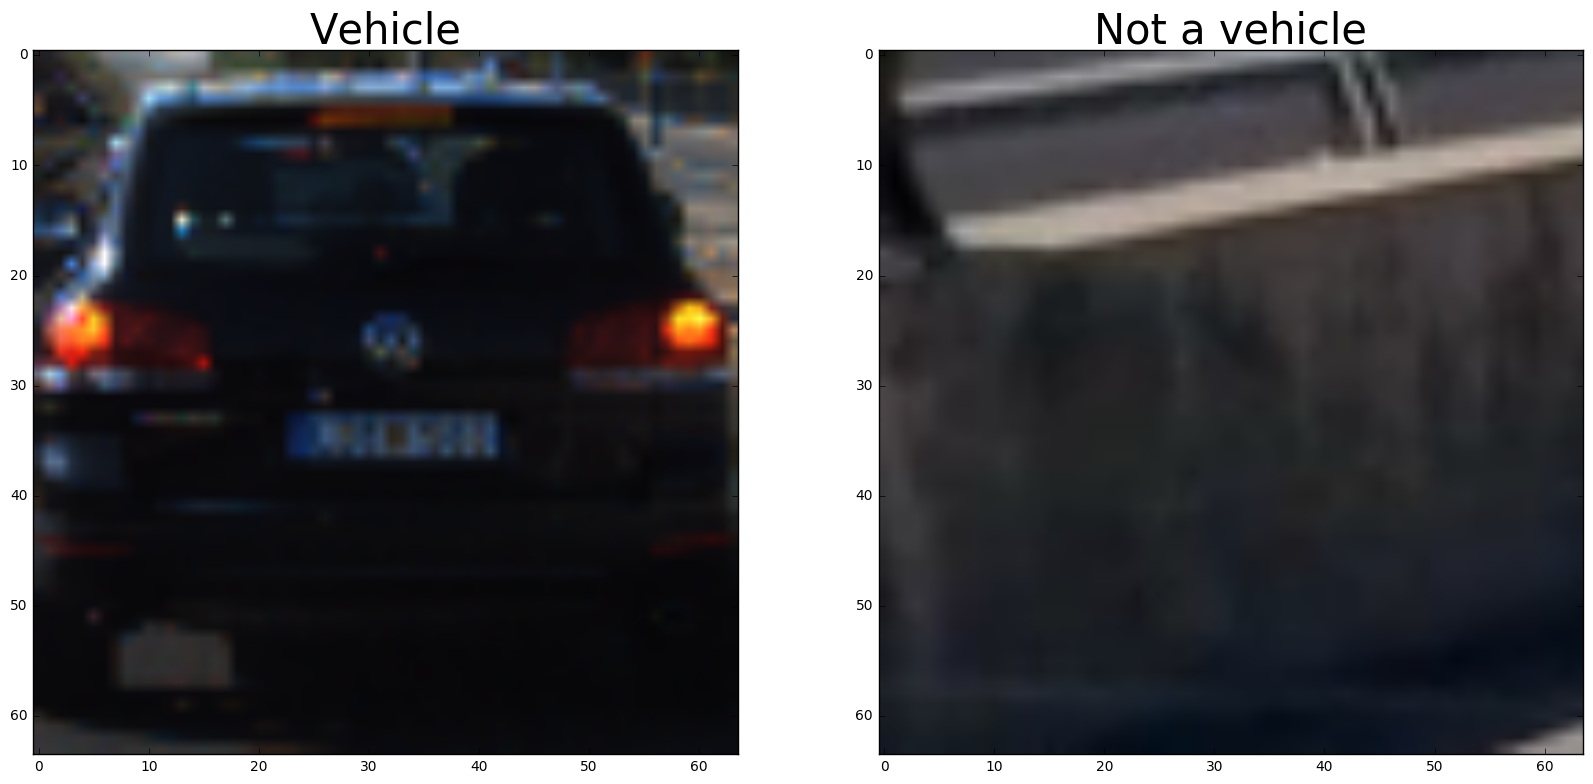

In [3]:
def show_two_images(img1, img2, title1, title2):
    cmap = None if len(img1.shape) == 3 else 'gray'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)

ind1, ind2 = np.random.randint(0, len(non_vehicle_imgs), 2)
show_two_images(vehicle_imgs[ind1], non_vehicle_imgs[ind2], 'Vehicle', 'Not a vehicle')


In [4]:
color_conversions = [cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2LUV, cv2.COLOR_RGB2HLS, cv2.COLOR_RGB2YUV, cv2.COLOR_RGB2YCrCb]
def bin_spatial(img, color_conversion=None, size=(16, 16)):
    # Convert image to new color space (if specified)
    if color_conversion is not None:
        feature_image = cv2.cvtColor(img, color_conversion)
    else:
        feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [5]:
def get_hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False):
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, transform_sqrt=False, visualise=False, feature_vector=True)
    hog_features = hog_features.ravel()
    return hog_features

In [6]:
x_list = []
for img in all_imgs:
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    bin_spatial_features = bin_spatial(img_hls, color_conversion=None)
    hog_features_h = get_hog(img_hls[:,:,0])
    hog_features_l = get_hog(img_hls[:,:,1])
    hog_features_s = get_hog(img_hls[:,:,2])
    img_features = np.concatenate((bin_spatial_features, hog_features_h, hog_features_l, hog_features_s))
    x_list.append(img_features)
print(bin_spatial_features.shape, hog_features_h.shape)

(768,) (1764,)


In [7]:
def get_feature_vector(image):
    image_resized = cv2.resize(image, (64, 64), cv2.INTER_AREA)
    image_hls = cv2.cvtColor(image_resized, cv2.COLOR_RGB2HLS)
    bin_spatial_features = bin_spatial(image_hls, color_conversion=None)
    hog_features_h = get_hog(image_hls[:,:,0])
    hog_features_l = get_hog(image_hls[:,:,1])
    hog_features_s = get_hog(image_hls[:,:,2])
    img_features = np.concatenate((bin_spatial_features, hog_features_h, hog_features_l, hog_features_s))
    return img_features

In [8]:
x = np.vstack(x_list).astype(np.float64)
x_scaler = StandardScaler().fit(x)
x = x_scaler.transform(x)
y = np.array([1] * num_vehicles + [0] * num_non_vehicles)
print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

(17770, 6060) (17770,)


In [10]:
clf = SVC(kernel='rbf', random_state=7)
clf.fit(x_train, y_train) 
print(clf.score(x_test, y_test))

0.993809791784


In [11]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [ ]:
with open('clf.pickle', 'rb') as f:
    clf = pickle.load(f)

In [14]:
with open('clf.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [34]:
image = cv2.imread('frames/frame25.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
y_start_stop=[int(image.shape[0]/2), int(image.shape[0])]
window_sizes = [(64, 64), (96, 96), (128, 128), (160, 160), (192, 192), (224, 224)]
windows = [] 
for window_size in window_sizes:
    new_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=window_size, 
                               xy_overlap=(0.75, 0.75))
    windows.extend(new_windows)

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)     

[((816, 408), (912, 504)), ((840, 408), (936, 504)), ((832, 392), (960, 520)), ((1056, 360), (1248, 552))]


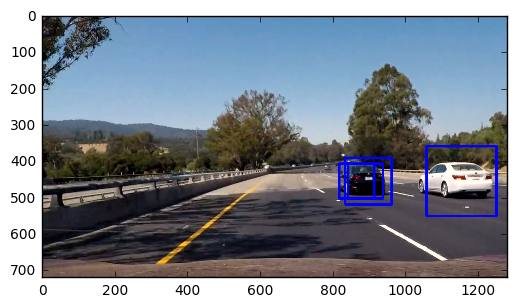

In [35]:
vehicle_windows = []
for window in windows:
    img_section = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    img_section_features = get_feature_vector(img_section)
    img_section_features = x_scaler.transform([img_section_features])[0]
    pred = clf.predict([img_section_features])[0]
    if pred == 1:
        vehicle_windows.append(window)
print(vehicle_windows)
image_vehicles = draw_boxes(image, vehicle_windows, color=(0, 0, 255), thick=6)
plt.imshow(image_vehicles)

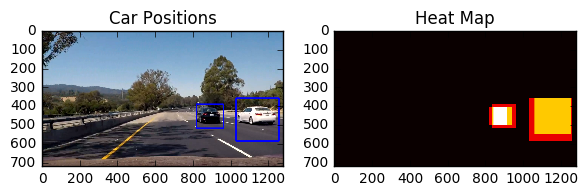

In [15]:
box_list = vehicle_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, box_list)
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


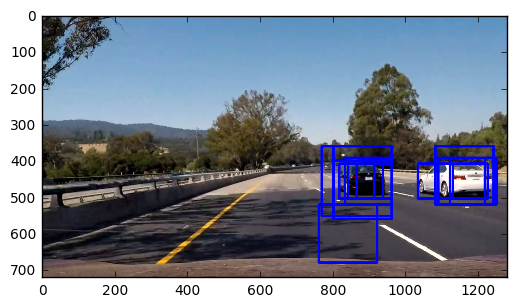

In [36]:
def find_cars(img, ystart, ystop, scale, clf, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2):    
    vehicle_windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = hog(ch1, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=False, feature_vector=False)
    hog2 = hog(ch2, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=False, feature_vector=False)
    hog3 = hog(ch3, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=False, feature_vector=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, color_conversion=None)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                vehicle_window = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                vehicle_windows.append(vehicle_window)
    return vehicle_windows

y_start=int(image.shape[0]/2)
y_stop=int(image.shape[0])
scales = [1, 1.5, 2, 2.5, 3, 3.5]
vehicle_windows = []
for scale in scales:    
    vehicle_windows.extend(find_cars(image, y_start, y_stop, scale, clf, x_scaler))
out_img = draw_boxes(image, vehicle_windows, color=(0, 0, 255), thick=6)
plt.imshow(out_img)

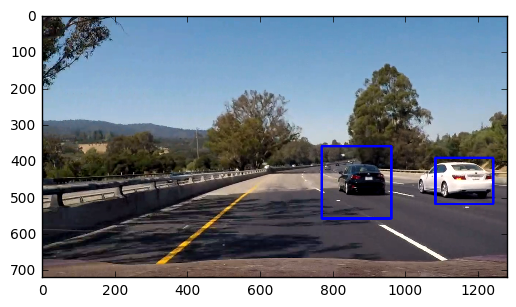

In [48]:
# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, vehicle_windows)
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)

In [49]:
i = 0
def process_image(image):
    #global i
    #cv2.imwrite('frames/frame' + str(i) + '.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #i += 1
    y_start=int(image.shape[0]/2)
    y_stop=int(image.shape[0])
    scales = [1, 1.5, 2, 2.5, 3, 3.5]
    vehicle_windows = []
    for scale in scales:    
        vehicle_windows.extend(find_cars(image, y_start, y_stop, scale, clf, x_scaler))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, vehicle_windows)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    return draw_img

In [50]:
output = 'processed.mp4'
clip = VideoFileClip('test_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video processed.mp4
[MoviePy] Writing video processed.mp4


 97%|█████████▋| 38/39 [21:20<00:33, 33.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed.mp4 

CPU times: user 21min 19s, sys: 1.25 s, total: 21min 20s
Wall time: 21min 20s
